# SEGMENTATION MODEL

## Prepare Library, Parameters, and Dependencies

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib
import itertools
import os
from tqdm import tqdm

%matplotlib inline

In [2]:
# UNCOMMENT THIS IF YOU USE GOOGLE COLAB

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Check TensorFlow Version and GPU Availability
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.14.0
Num GPUs Available:  1


In [4]:
# Set Parameters
SEG_DATASET_DIR = '/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/'
SEG_TEST_DATASET_DIR = '/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/'
SAVE_MODEL_PATH = '/content/drive/MyDrive/Skripsi/v_0.0.2/models/segmentation_model_1/'
TEST_PREDICT_DIR = '/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/'

BATCH_SIZE_SEG = 8
VAL_RATIO_SEG = 0.2
SHUFFLE_BUFFER_SIZE_SEG = 10000

IMG_HEIGHT = 128
IMG_WIDTH = 128

SHUFFLE_VALUE = True
AUTOTUNE = tf.data.AUTOTUNE

## Model #1 (U-Net Vanilla w/ Grayscaling)

#### Load Dataset Path

In [5]:
# USE THIS IF YOU USE LOCAL MACHINE

# # Load OG Image Path
# image_path = []
# for root, dirs, files in os.walk(SEG_DATASET + "/train_original/"):
#     for file in files:
#         if file.endswith(".jpg"):
#              image_path.append(os.path.join(root, file))
# print(len(image_path))
# print(image_path[1])

# # Load Mask Image Path
# mask_path = []
# for root, dirs, files in os.walk(SEG_DATASET + "/train_mask/"):
#     for file in files:
#         if file.endswith(".jpg"):
#              mask_path.append(os.path.join(root, file))
# print(len(mask_path))
# print(mask_path[1])

In [6]:
# USE THIS IF YOU USE GOOGLE COLAB

# Load OG Image and Mask Image Path
image_path = []
mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_original'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_mask',file)
        image_path.append(path_og)
        mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(image_path))
print(image_path[1])
print(len(mask_path))
print(mask_path[1])

1476
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_original/SID1500_jpg.rf.f5c7d2a453dc28aa39e1858fca91e955.jpg
1476
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_mask/SID1500_jpg.rf.f5c7d2a453dc28aa39e1858fca91e955.jpg


#### Load and Grayscaling Dataset

In [7]:
# Load and Grayscale Mask Image
masks = []
for path in tqdm(mask_path):
    mask = cv2.imread(path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    masks.append(mask)

# Load and Grayscale OG Image
images = []
for path in tqdm(image_path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images.append(image)

100%|██████████| 1476/1476 [00:09<00:00, 164.00it/s]


#### Clear Outlier on Mask Dataset

In [8]:
# Clear Outlier
for mask in masks:
    mask[mask < 127] = 0
    mask[mask >= 127] = 255

#### Visualize Dataset

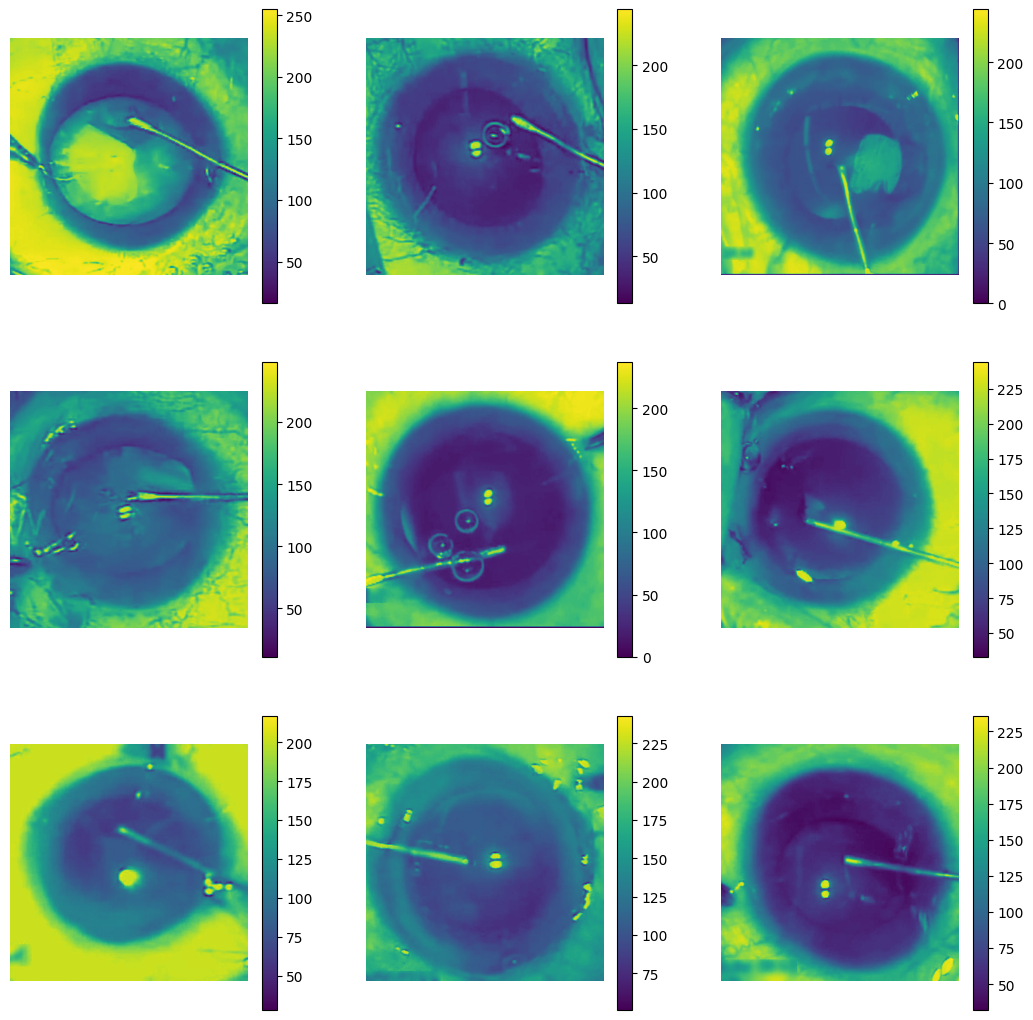

In [9]:
# Visualize Dataset OG Image
plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.colorbar()
    plt.axis("off")

plt.show()

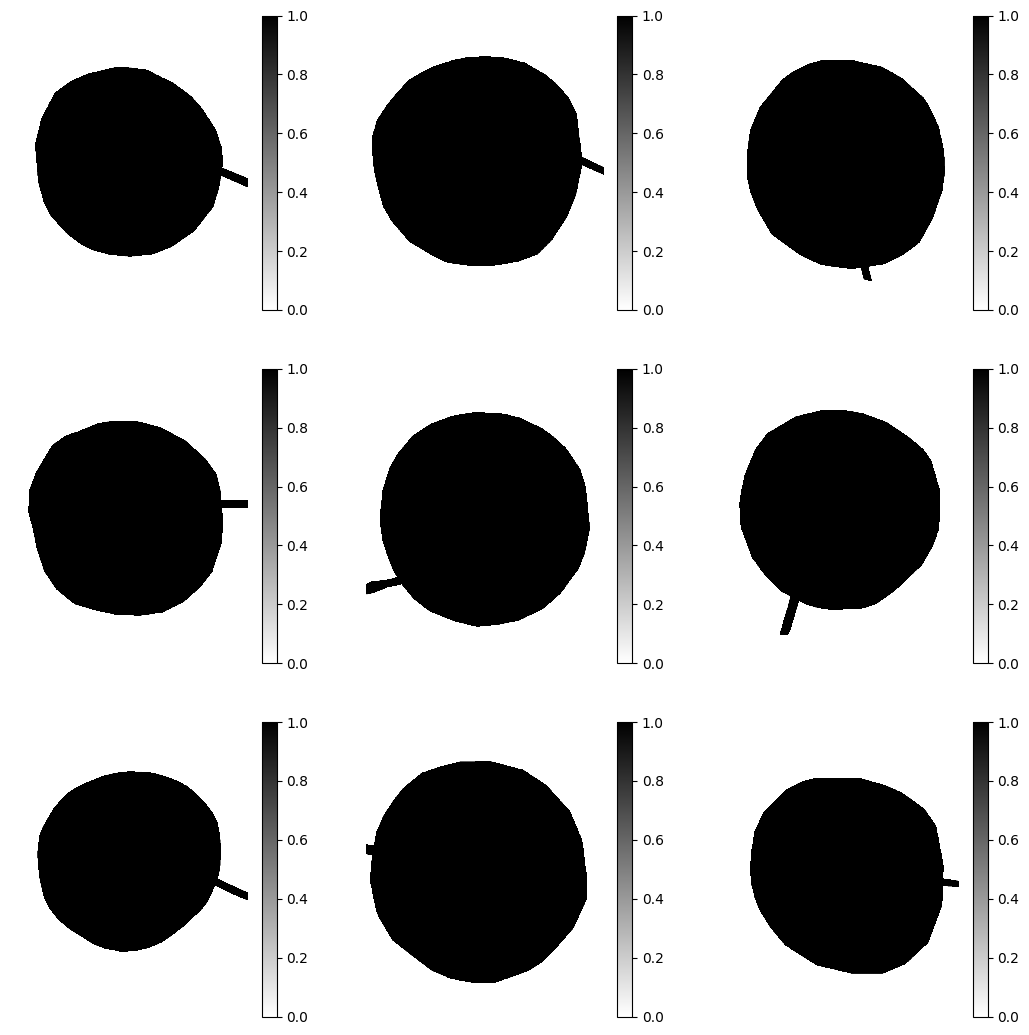

In [10]:
# Visualize Dataset Mask Image
NORM = mpl.colors.Normalize(vmin=0, vmax=1)

plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(masks[i], cmap='binary', norm=NORM)
    plt.colorbar()
    plt.axis("off")

plt.show()

#### Resize Dataset

In [11]:
# Resize Function for Dataset OG Image
def resize_image(image):
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = image / 255
    return image

# Resize Function for Dataset Mask Image
def resize_mask(mask):
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = mask / 255
    mask = mask.astype(np.uint8)
    return mask

In [12]:
# Resize Dataset OG and Mask Image
X = [resize_image(image) for image in images]
y = [resize_mask(mask) for mask in masks]

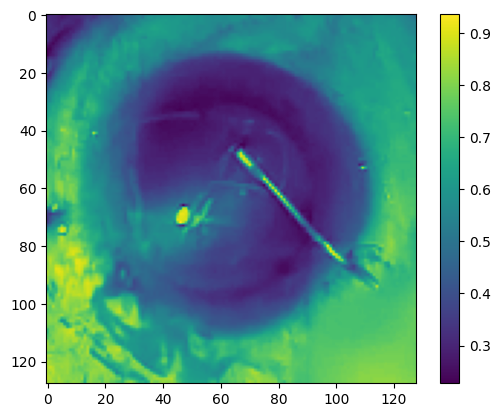

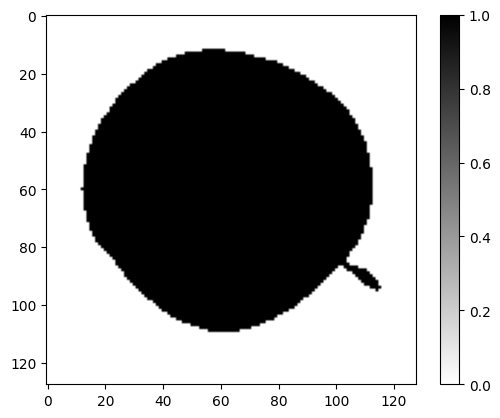

In [13]:
# Visualizing a Resized Image and Respective Mask

# Plot an OG Image
plt.imshow(X[36])
plt.colorbar()
plt.show()

# Plot a Mask
plt.imshow(y[36], cmap='binary')
plt.colorbar()
plt.show()

#### Split Dataset & Change Dataset Into TensorFlow Dataset

In [14]:
# Split Dataset With 80/20 Ratio
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_RATIO_SEG, random_state=42)

# Change Dataset Into TensorFlow Dataset
X_train = tf.data.Dataset.from_tensor_slices(X_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)
X_val = tf.data.Dataset.from_tensor_slices(X_val)
y_val = tf.data.Dataset.from_tensor_slices(y_val)

# Verify the Shapes and Data Types
X_train.element_spec, y_train.element_spec, X_val.element_spec, y_val.element_spec

(TensorSpec(shape=(128, 128), dtype=tf.float64, name=None),
 TensorSpec(shape=(128, 128), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128), dtype=tf.float64, name=None),
 TensorSpec(shape=(128, 128), dtype=tf.uint8, name=None))

#### Dataset Augmentation

In [15]:
# Data Augmentation Function
def add_dimensional(image, mask):
    image = tf.expand_dims(image, -1)
    mask = tf.expand_dims(mask, -1)
    return image, mask

def brightness(image, mask):
    image = tf.image.adjust_brightness(image, 0.1)
    return image, mask

def gamma(image, mask):
    image = tf.image.adjust_gamma(image, 0.1)
    return image, mask

def hue(image, mask):
    image = tf.image.adjust_hue(image, -0.1)
    return image, mask

def crop(image, mask):
    image = tf.image.central_crop(image, 0.7)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    return image, mask

def flip_hori(image, mask):
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
    return image, mask

def flip_vert(image, mask):
    image = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)
    return image, mask

def rotate(image, mask):
    image = tf.image.rot90(image)
    mask = tf.image.rot90(mask)
    return image, mask

In [16]:
# Zip Dataset
train = tf.data.Dataset.zip((X_train, y_train))
val = tf.data.Dataset.zip((X_val, y_val))

In [17]:
# Perform Data Augmentation
train = train.map(add_dimensional)
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(gamma))
# train = train.concatenate(train.map(hue))
# train = train.concatenate(train.map(crop))
train = train.concatenate(train.map(flip_hori))
train = train.concatenate(train.map(flip_vert))
train = train.concatenate(train.map(rotate))

#### Dataset Pipelining

In [18]:
train = train.cache().shuffle(SHUFFLE_BUFFER_SIZE_SEG).batch(BATCH_SIZE_SEG).repeat()
train = train.prefetch(AUTOTUNE)
val = val.batch(BATCH_SIZE_SEG)

#### Callbacks

In [19]:
stop_callback = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

#### Model Architecture

In [20]:
# Encoder Block for Contracting Path in U-Net Architecture
def EncoderBlock(input_layer, n_filter, kernel_size=(3,3), kernel_initializer='he_normal', dropout_prob=0.1, max_pooling=True):
    x = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(input_layer)

    if dropout_prob > 0:
        x = keras.layers.Dropout(dropout_prob)(x)

    x = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    if max_pooling:
        next_layer = keras.layers.MaxPooling2D((2,2))(x)
    else:
        next_layer = x

    skip_connection = x

    return next_layer, skip_connection

# Decoder Block for Expansive Path in U-Net Architecture
def DecoderBlock(input_layer, skip_layer, n_filter, kernel_size=(2,2), kernel_initializer='he_normal', dropout_prob=0.1):
    x = keras.layers.Conv2DTranspose(n_filter, kernel_size, strides=(2,2), padding='same')(input_layer)
    x = keras.layers.concatenate([x, skip_layer])
    x = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    if dropout_prob > 0:
        x = keras.layers.Dropout(dropout_prob)(x)

    next_layer = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    return next_layer

# Morphology Closing Function
def morphology_peration(input_layer):
    morphed_image = cv2.morphologyEx(input_layer, cv2.MORPH_CLOSE, kernel)

In [21]:
# Input Layer
input_layer = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 1), name="input_image")

# Build Contraction Path
c1, s1 = EncoderBlock(input_layer, 16)
c2, s2 = EncoderBlock(c1, 32)
c3, s3 = EncoderBlock(c2, 64)
c4, s4 = EncoderBlock(c3, 128)
c5, _ = EncoderBlock(c4, 256, max_pooling=False)

# Build Expansive Path
e1 = DecoderBlock(c5, s4, 128)
e2 = DecoderBlock(e1, s3, 64)
e3 = DecoderBlock(e2, s2, 32)
e4 = DecoderBlock(e3, s1, 16)

# Output Layer
output = keras.layers.Conv2D(1, (1,1), activation='sigmoid')(e4)

# Initialize Model
unet = keras.Model(inputs=[input_layer], outputs=[output])

In [22]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         160       ['input_image[0][0]']         
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['dropout[0][0]']             
                                                                                              

#### Train Model

In [23]:
unet.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [24]:
model_history = unet.fit(
    train,
    validation_data=val,
    steps_per_epoch=(len(X_train) // BATCH_SIZE_SEG),
    validation_steps=len(X_val) // BATCH_SIZE_SEG,
    epochs=50,
    verbose=2,
    callbacks=[stop_callback]
)

Epoch 1/50
147/147 - 19s - loss: 0.3839 - accuracy: 0.8267 - val_loss: 0.2488 - val_accuracy: 0.9099 - 19s/epoch - 126ms/step
Epoch 2/50
147/147 - 4s - loss: 0.2218 - accuracy: 0.9096 - val_loss: 0.1718 - val_accuracy: 0.9395 - 4s/epoch - 27ms/step
Epoch 3/50
147/147 - 4s - loss: 0.2015 - accuracy: 0.9191 - val_loss: 0.2229 - val_accuracy: 0.9384 - 4s/epoch - 27ms/step
Epoch 4/50
147/147 - 4s - loss: 0.1789 - accuracy: 0.9284 - val_loss: 0.1347 - val_accuracy: 0.9520 - 4s/epoch - 27ms/step
Epoch 5/50
147/147 - 4s - loss: 0.1549 - accuracy: 0.9379 - val_loss: 0.1601 - val_accuracy: 0.9387 - 4s/epoch - 27ms/step
Epoch 6/50
147/147 - 4s - loss: 0.1397 - accuracy: 0.9446 - val_loss: 0.1236 - val_accuracy: 0.9537 - 4s/epoch - 27ms/step
Epoch 7/50
147/147 - 4s - loss: 0.1329 - accuracy: 0.9474 - val_loss: 0.1127 - val_accuracy: 0.9559 - 4s/epoch - 27ms/step
Epoch 8/50
147/147 - 4s - loss: 0.1319 - accuracy: 0.9466 - val_loss: 0.1093 - val_accuracy: 0.9591 - 4s/epoch - 27ms/step
Epoch 9/50
14

#### Visualize Accuracy and Loss

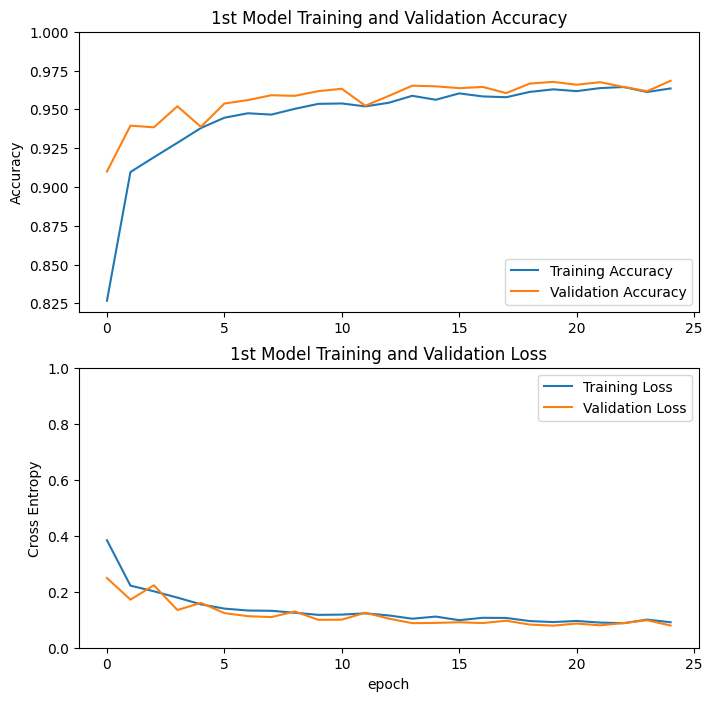

In [25]:
# Retrieve Accuracy and Loss from Segmentation Model
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('1st Model Training and Validation Accuracy')

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('1st Model Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Evaluate Model With Test Dataset

In [26]:
# Load Test Dataset OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk(SEG_TEST_DATASET_DIR + 'test_original'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join(SEG_TEST_DATASET_DIR + 'test_mask/', file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])
print(len(test_mask_path))
print(test_mask_path[1])

# Load and Grayscale Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = cv2.imread(path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    test_masks.append(mask)

# Load and Grayscale OG Image
test_images = []
for path in tqdm(test_image_path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    test_images.append(image)

# Clear Outlier
for mask in test_masks:
    mask[mask < 127] = 0
    mask[mask >= 127] = 255

# Resize Test Dataset OG and Mask Image
X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

# Change Dataset Into TensorFlow Dataset
X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

# Dataset Pipelining
test = test.batch(BATCH_SIZE_SEG)

129
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_original/SID0635_jpg.rf.3d96657ecde6f846f158b241fc735110.jpg
129
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_mask/SID0635_jpg.rf.3d96657ecde6f846f158b241fc735110.jpg


100%|██████████| 129/129 [00:00<00:00, 156.73it/s]


In [27]:
# Evaluate Model
loss, accuracy = unet.evaluate(test)

17/17 [==============================] - 1s 38ms/step - loss: 0.0938 - accuracy: 0.9627


1/1 [==============================] - 0s 266ms/step


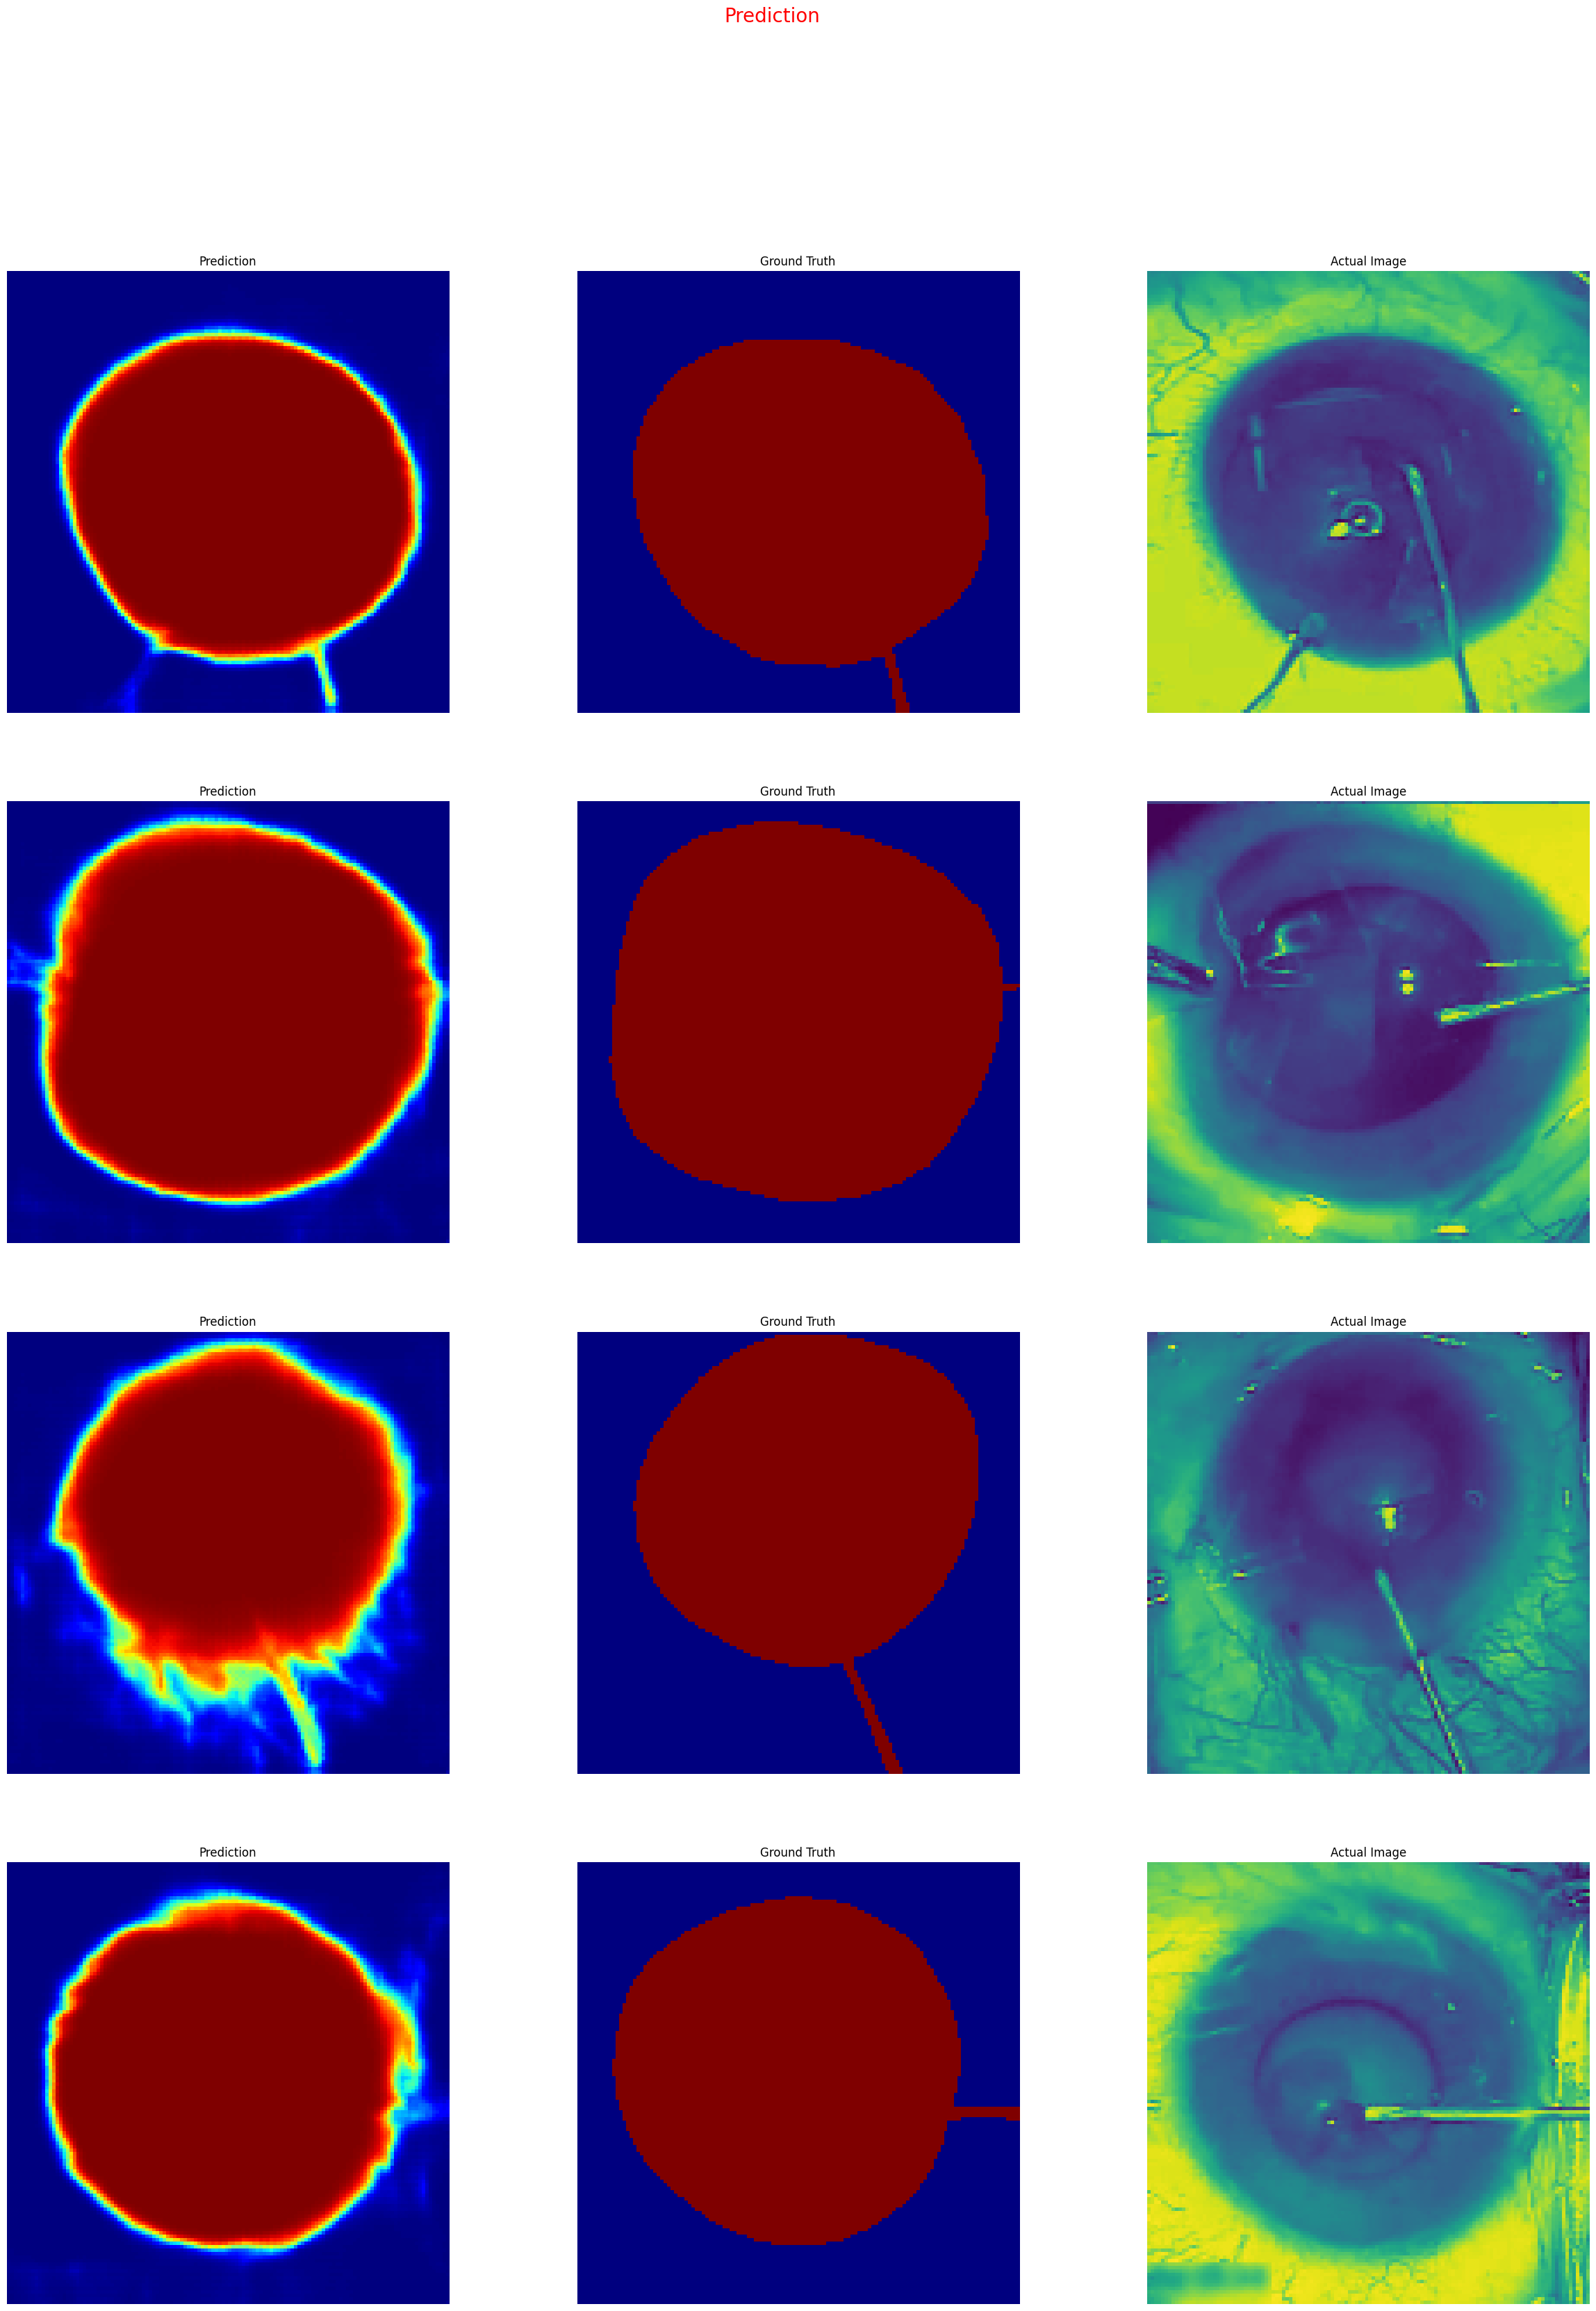

In [28]:
# Select a Test Data Batch
img, mask = next(iter(test))

# Make Prediction from Test Data Batch
pred = unet.predict(img)
plt.figure(figsize=(30,38))

for i in pred:
    i = i * 255

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4,3,1+k*3)
    plt.imshow(i, cmap='jet')
    plt.axis('off')
    plt.title('Prediction')

    # Plot the Groundtruth Mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Ground Truth')

    # Plot the Actual Image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction', color='red', size=20)
plt.show()

#### Test With Cataract Dataset

In [29]:
# Load Cataract OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk(TEST_PREDICT_DIR):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join(TEST_PREDICT_DIR,file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])
print(len(test_mask_path))
print(test_mask_path[1])

# Load and Grayscale Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = cv2.imread(path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    test_masks.append(mask)

# Load and Grayscale OG Image
test_images = []
for path in tqdm(test_image_path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    test_images.append(image)

# Resize Dataset OG and Mask Image
X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

# Change Dataset Into TensorFlow Dataset
X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

# Dataset Pipelining
test = test.batch(BATCH_SIZE_SEG)

3
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/katarak_matur1.jpg
3
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/katarak_matur1.jpg


100%|██████████| 3/3 [00:00<00:00, 49.41it/s]


1/1 [==============================] - 1s 557ms/step


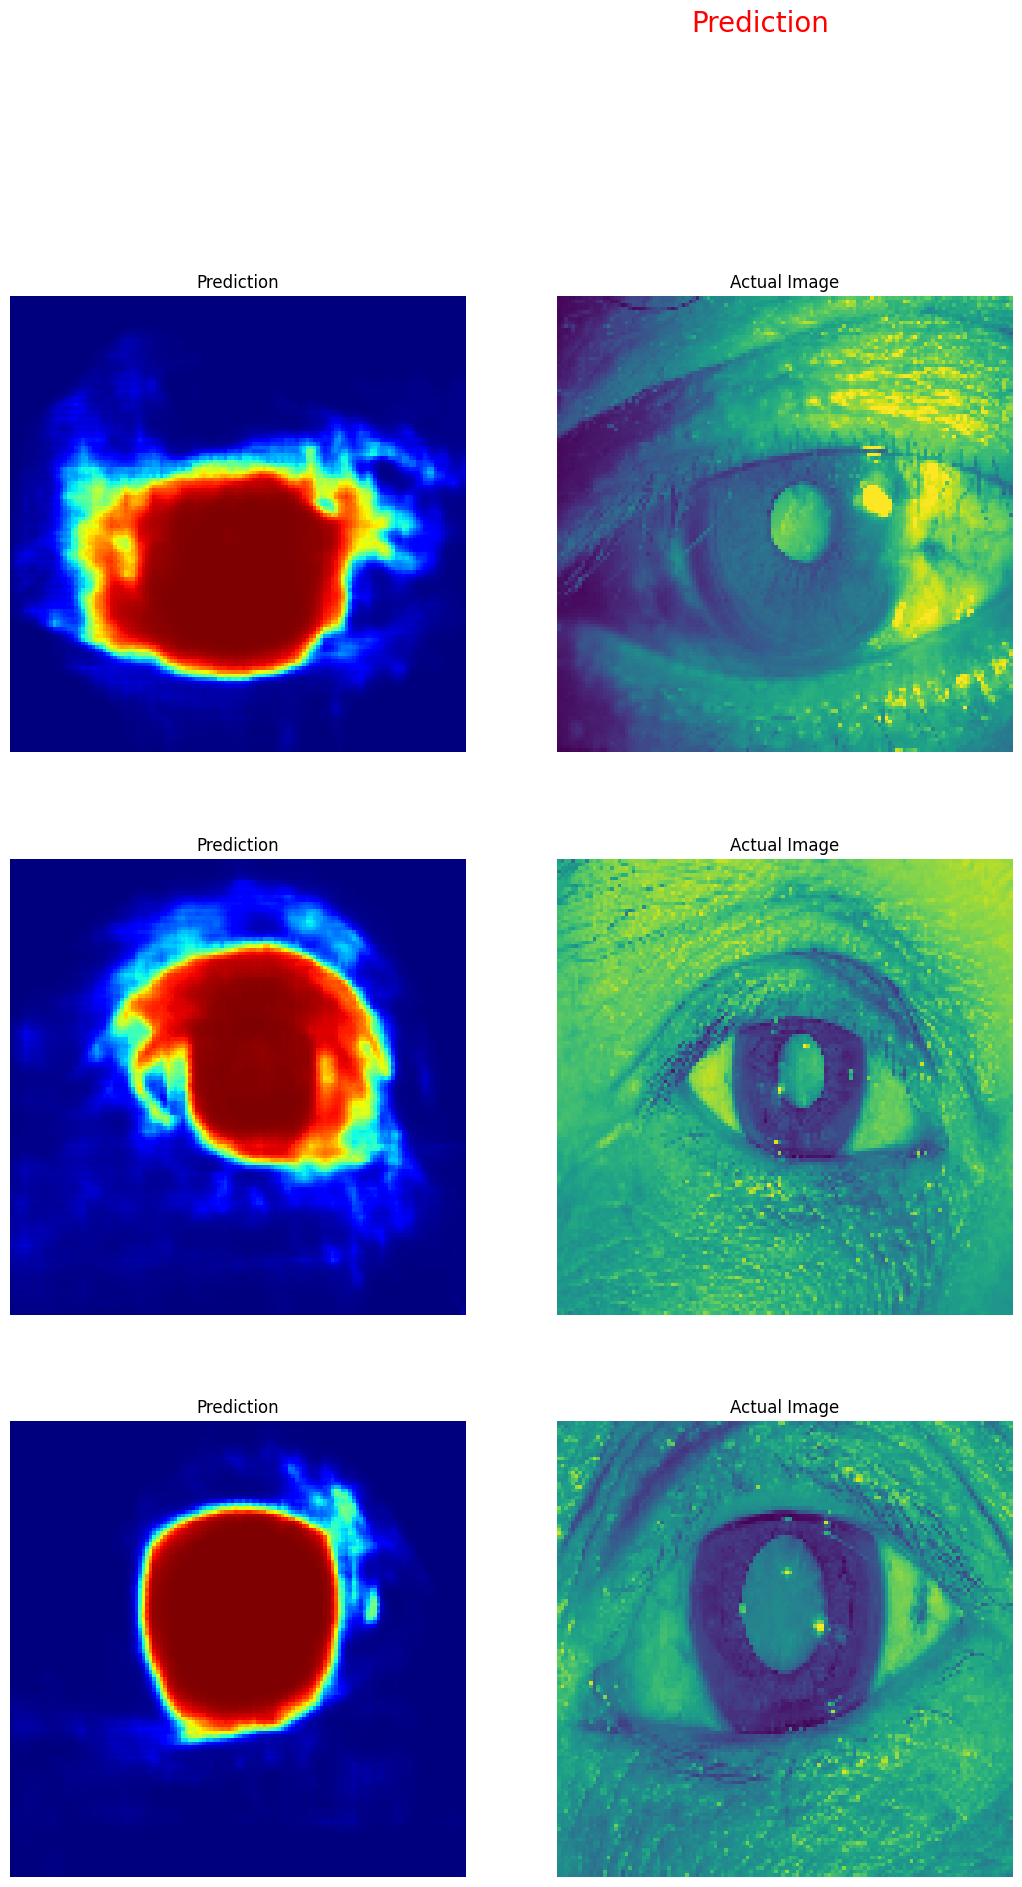

In [30]:
# Select a Cataract Test Data Batch
img, mask = next(iter(test))

# Make Prediction
pred = unet.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4,3,1+k*3)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # Plot the Actual Image
    plt.subplot(4,3,2+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction', color='red', size=20)
plt.show()

## Model #2 (U-Net Vanilla w/ Morphology Closing)

#### Load Dataset Path

In [31]:
# USE THIS IF YOU USE LOCAL MACHINE

# # Load OG Image Path
# image_path = []
# for root, dirs, files in os.walk(SEG_DATASET + "/train_original/"):
#     for file in files:
#         if file.endswith(".jpg"):
#              image_path.append(os.path.join(root, file))
# print(len(image_path))
# print(image_path[1])

# # Load Mask Image Path
# mask_path = []
# for root, dirs, files in os.walk(SEG_DATASET + "/train_mask/"):
#     for file in files:
#         if file.endswith(".jpg"):
#              mask_path.append(os.path.join(root, file))
# print(len(mask_path))
# print(mask_path[1])

In [32]:
# USE THIS IF YOU USE GOOGLE COLAB

# Load OG Image and Mask Image Path
image_path = []
mask_path = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_original'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_mask',file)
        image_path.append(path_og)
        mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(image_path))
print(image_path[1])
print(len(mask_path))
print(mask_path[1])

1476
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_original/SID1500_jpg.rf.f5c7d2a453dc28aa39e1858fca91e955.jpg
1476
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/train_mask/SID1500_jpg.rf.f5c7d2a453dc28aa39e1858fca91e955.jpg


#### Load Dataset

In [33]:
# Load and Grayscale Mask Image
masks = []
for path in tqdm(mask_path):
    mask = cv2.imread(path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    masks.append(mask)

# Load OG Image
images = []
for path in tqdm(image_path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

100%|██████████| 1476/1476 [00:07<00:00, 196.57it/s]


#### Clear Outlier on Mask Dataset

In [34]:
# Clear Outlier
for mask in masks:
    mask[mask < 127] = 0
    mask[mask >= 127] = 255

#### Visualize Dataset

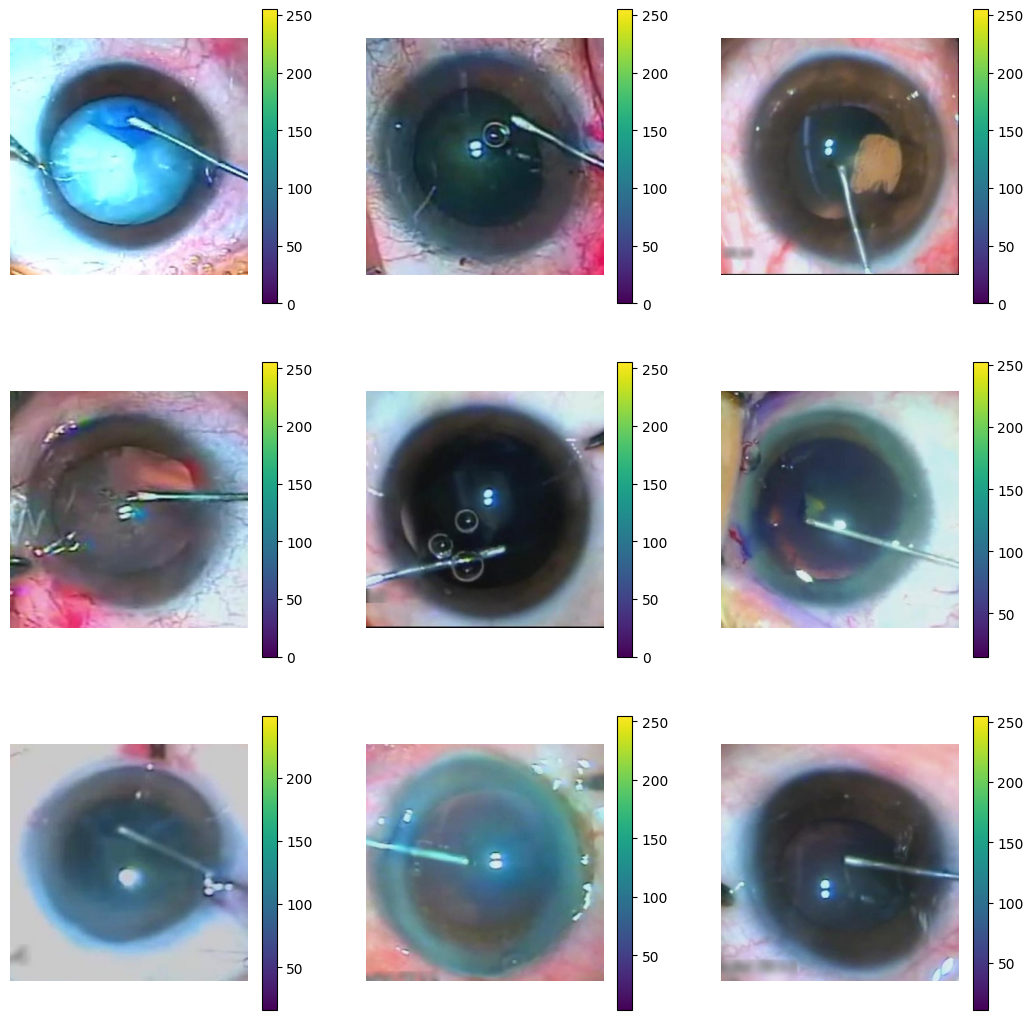

In [35]:
# Visualize Dataset OG Image
plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.colorbar()
    plt.axis("off")

plt.show()

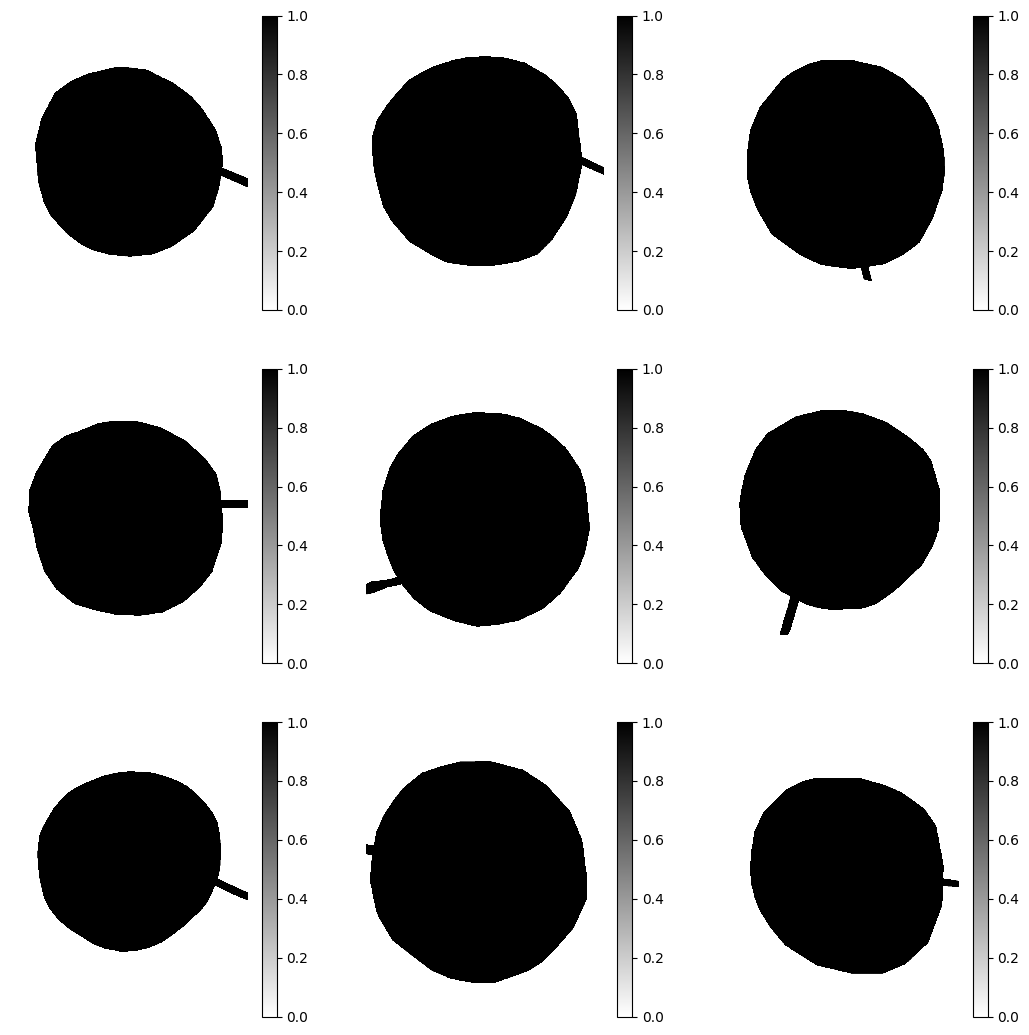

In [36]:
# Visualize Dataset Mask Image
NORM = mpl.colors.Normalize(vmin=0, vmax=1)

plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(masks[i], cmap='binary', norm=NORM)
    plt.colorbar()
    plt.axis("off")

plt.show()

#### Resize Dataset

In [37]:
# Resize Function for Dataset OG Image
def resize_image(image):
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = image / 255
    return image

# Resize Function for Dataset Mask Image
def resize_mask(mask):
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = mask.astype(np.uint8)
    return mask

In [38]:
# Resize Dataset OG and Mask Image
X = [resize_image(image) for image in images]
y = [resize_mask(mask) for mask in masks]

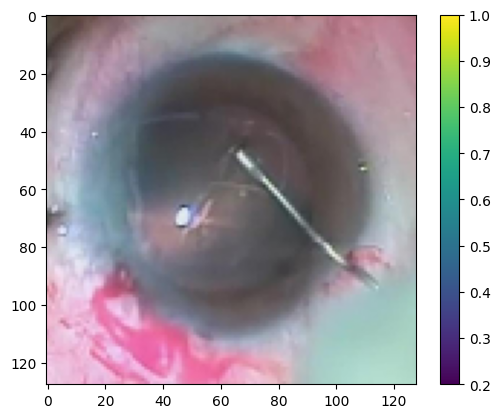

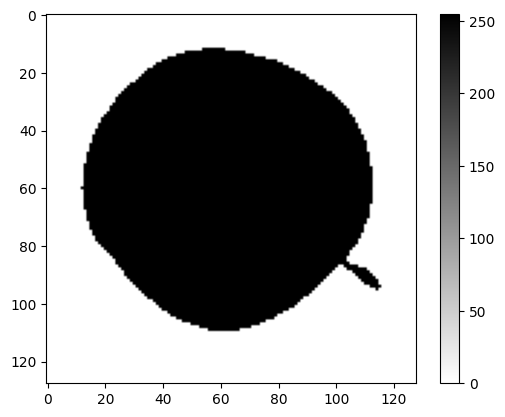

In [39]:
# Visualizing a Resized Image and Respective Mask

# Plot an OG Image
plt.imshow(X[36])
plt.colorbar()
plt.show()

# Plot a Mask
plt.imshow(y[36], cmap='binary')
plt.colorbar()
plt.show()

#### Split Dataset & Change Dataset Into TensorFlow Dataset

In [40]:
# Split Dataset With 80/20 Ratio
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_RATIO_SEG, random_state=122)

# Change Dataset Into TensorFlow Dataset
X_train = tf.data.Dataset.from_tensor_slices(X_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)
X_val = tf.data.Dataset.from_tensor_slices(X_val)
y_val = tf.data.Dataset.from_tensor_slices(y_val)

# Verify the Shapes and Data Types
X_train.element_spec, y_train.element_spec, X_val.element_spec, y_val.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(128, 128), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(128, 128), dtype=tf.uint8, name=None))

#### Dataset Augmentation

In [41]:
# Data Augmentation Function
def add_dimensional(image, mask):
    mask = tf.expand_dims(mask, -1)
    image = tf.cast(image, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.uint8)
    return image, mask

def brightness(image, mask):
    image = tf.image.adjust_brightness(image, 0.1)
    return image, mask

def gamma(image, mask):
    image = tf.image.adjust_gamma(image, 0.1)
    return image, mask

def hue(image, mask):
    image = tf.image.adjust_hue(image, -0.1)
    return image, mask

def crop(image, mask):
    image = tf.image.central_crop(image, 0.7)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return image, mask

def flip_hori(image, mask):
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
    return image, mask

def flip_vert(image, mask):
    image = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)
    return image, mask

def rotate(image, mask):
    image = tf.image.rot90(image)
    mask = tf.image.rot90(mask)
    return image, mask

In [42]:
# Zip Dataset
train = tf.data.Dataset.zip((X_train, y_train))
val = tf.data.Dataset.zip((X_val, y_val))

# Perform Data Augmentation
train = train.map(add_dimensional)
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(gamma))
# train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(crop))
train = train.concatenate(train.map(flip_hori))
train = train.concatenate(train.map(flip_vert))
train = train.concatenate(train.map(rotate))

#### Dataset Pipelining

In [43]:
train = train.cache().shuffle(SHUFFLE_BUFFER_SIZE_SEG).batch(BATCH_SIZE_SEG).repeat()
train = train.prefetch(AUTOTUNE)
val = val.batch(BATCH_SIZE_SEG)

#### Model Architecture

In [44]:
# Encoder Block for Contracting Path in U-Net Architecture
def EncoderBlock(input_layer, n_filter, kernel_size=(3,3), kernel_initializer='he_normal', dropout_prob=0.1, max_pooling=True):
    x = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(input_layer)

    if dropout_prob > 0:
        x = keras.layers.Dropout(dropout_prob)(x)

    x = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    if max_pooling:
        next_layer = keras.layers.MaxPooling2D((2,2))(x)
    else:
        next_layer = x

    skip_connection = x

    return next_layer, skip_connection

# Decoder Block for Expansive Path in U-Net Architecture
def DecoderBlock(input_layer, skip_layer, n_filter, kernel_size=(2,2), kernel_initializer='he_normal', dropout_prob=0.1):
    x = keras.layers.Conv2DTranspose(n_filter, kernel_size, strides=(2,2), padding='same')(input_layer)
    x = keras.layers.concatenate([x, skip_layer])
    x = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    if dropout_prob > 0:
        x = keras.layers.Dropout(dropout_prob)(x)

    next_layer = keras.layers.Conv2D(n_filter, kernel_size, activation='relu', kernel_initializer=kernel_initializer, padding='same')(x)

    return next_layer

In [45]:
# Input Layer
input_layer = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 3), name="input_image")

# Build Contraction Path
c1, s1 = EncoderBlock(input_layer, 16)
c2, s2 = EncoderBlock(c1, 32)
c3, s3 = EncoderBlock(c2, 64)
c4, s4 = EncoderBlock(c3, 128)
c5, _ = EncoderBlock(c4, 256, max_pooling=False)

# Build Expansive Path
e1 = DecoderBlock(c5, s4, 128)
e2 = DecoderBlock(e1, s3, 64)
e3 = DecoderBlock(e2, s2, 32)
e4 = DecoderBlock(e3, s1, 16)

# Output Layer
output = keras.layers.Conv2D(256, (1,1), activation='sigmoid')(e4)

# Initialize Model
unet2 = keras.Model(inputs=[input_layer], outputs=[output])

In [46]:
unet2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 16)         448       ['input_image[0][0]']         
                                                                                                  
 dropout_9 (Dropout)         (None, 128, 128, 16)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 128, 128, 16)         2320      ['dropout_9[0][0]']           
                                                                                            

#### Train Model

In [47]:
unet2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [48]:
model_history2 = unet2.fit(
    train,
    validation_data=val,
    steps_per_epoch=len(X_train) // BATCH_SIZE_SEG,
    validation_steps=len(X_val) // BATCH_SIZE_SEG,
    epochs=50,
    verbose=2,
    callbacks=[stop_callback]
)

Epoch 1/50
147/147 - 17s - loss: 1.8091 - accuracy: 0.6050 - val_loss: 0.5360 - val_accuracy: 0.8639 - 17s/epoch - 115ms/step
Epoch 2/50
147/147 - 9s - loss: 0.6443 - accuracy: 0.7990 - val_loss: 0.4314 - val_accuracy: 0.9039 - 9s/epoch - 62ms/step
Epoch 3/50
147/147 - 9s - loss: 0.5260 - accuracy: 0.8461 - val_loss: 0.3606 - val_accuracy: 0.8931 - 9s/epoch - 62ms/step
Epoch 4/50
147/147 - 9s - loss: 0.4894 - accuracy: 0.8667 - val_loss: 0.2952 - val_accuracy: 0.9170 - 9s/epoch - 62ms/step
Epoch 5/50
147/147 - 9s - loss: 0.4219 - accuracy: 0.8906 - val_loss: 0.2464 - val_accuracy: 0.9295 - 9s/epoch - 61ms/step
Epoch 6/50
147/147 - 9s - loss: 0.3886 - accuracy: 0.9067 - val_loss: 0.2369 - val_accuracy: 0.9375 - 9s/epoch - 61ms/step
Epoch 7/50
147/147 - 9s - loss: 0.3787 - accuracy: 0.9124 - val_loss: 0.3467 - val_accuracy: 0.9028 - 9s/epoch - 61ms/step
Epoch 8/50
147/147 - 9s - loss: 0.4183 - accuracy: 0.9055 - val_loss: 0.2268 - val_accuracy: 0.9372 - 9s/epoch - 61ms/step
Epoch 9/50
14

#### Visualize Accuracy and Loss

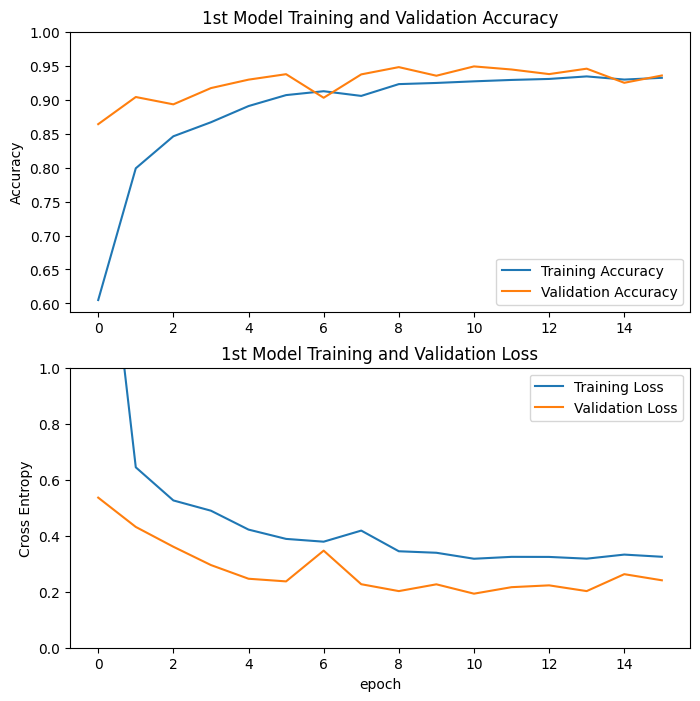

In [49]:
# Retrieve Accuracy and Loss from Segmentation Model
acc = model_history2.history['accuracy']
val_acc = model_history2.history['val_accuracy']
loss = model_history2.history['loss']
val_loss = model_history2.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('1st Model Training and Validation Accuracy')

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('1st Model Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Evaluate Model With Test Dataset

In [50]:
# Load Test Dataset OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk(SEG_TEST_DATASET_DIR + 'test_original'):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join(SEG_TEST_DATASET_DIR + 'test_mask/', file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])
print(len(test_mask_path))
print(test_mask_path[1])

# Load and Grayscale Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = cv2.imread(path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    test_masks.append(mask)

# Load and Grayscale OG Image
test_images = []
for path in tqdm(test_image_path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(image)

# Clear Outlier
for mask in test_masks:
    mask[mask < 127] = 0
    mask[mask >= 127] = 255

# Resize Test Dataset OG and Mask Image
X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

# Change Dataset Into TensorFlow Dataset
X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

# Dataset Pipelining
test = test.batch(BATCH_SIZE_SEG)

129
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_original/SID0635_jpg.rf.3d96657ecde6f846f158b241fc735110.jpg
129
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/segmentation_datasets/iris_needle_seg_dataset_mixed/test_mask/SID0635_jpg.rf.3d96657ecde6f846f158b241fc735110.jpg


100%|██████████| 129/129 [00:00<00:00, 147.39it/s]


In [51]:
# Evaluate Model
loss, accuracy = unet2.evaluate(test)

17/17 [==============================] - 1s 37ms/step - loss: 0.2060 - accuracy: 0.9293


1/1 [==============================] - 0s 255ms/step


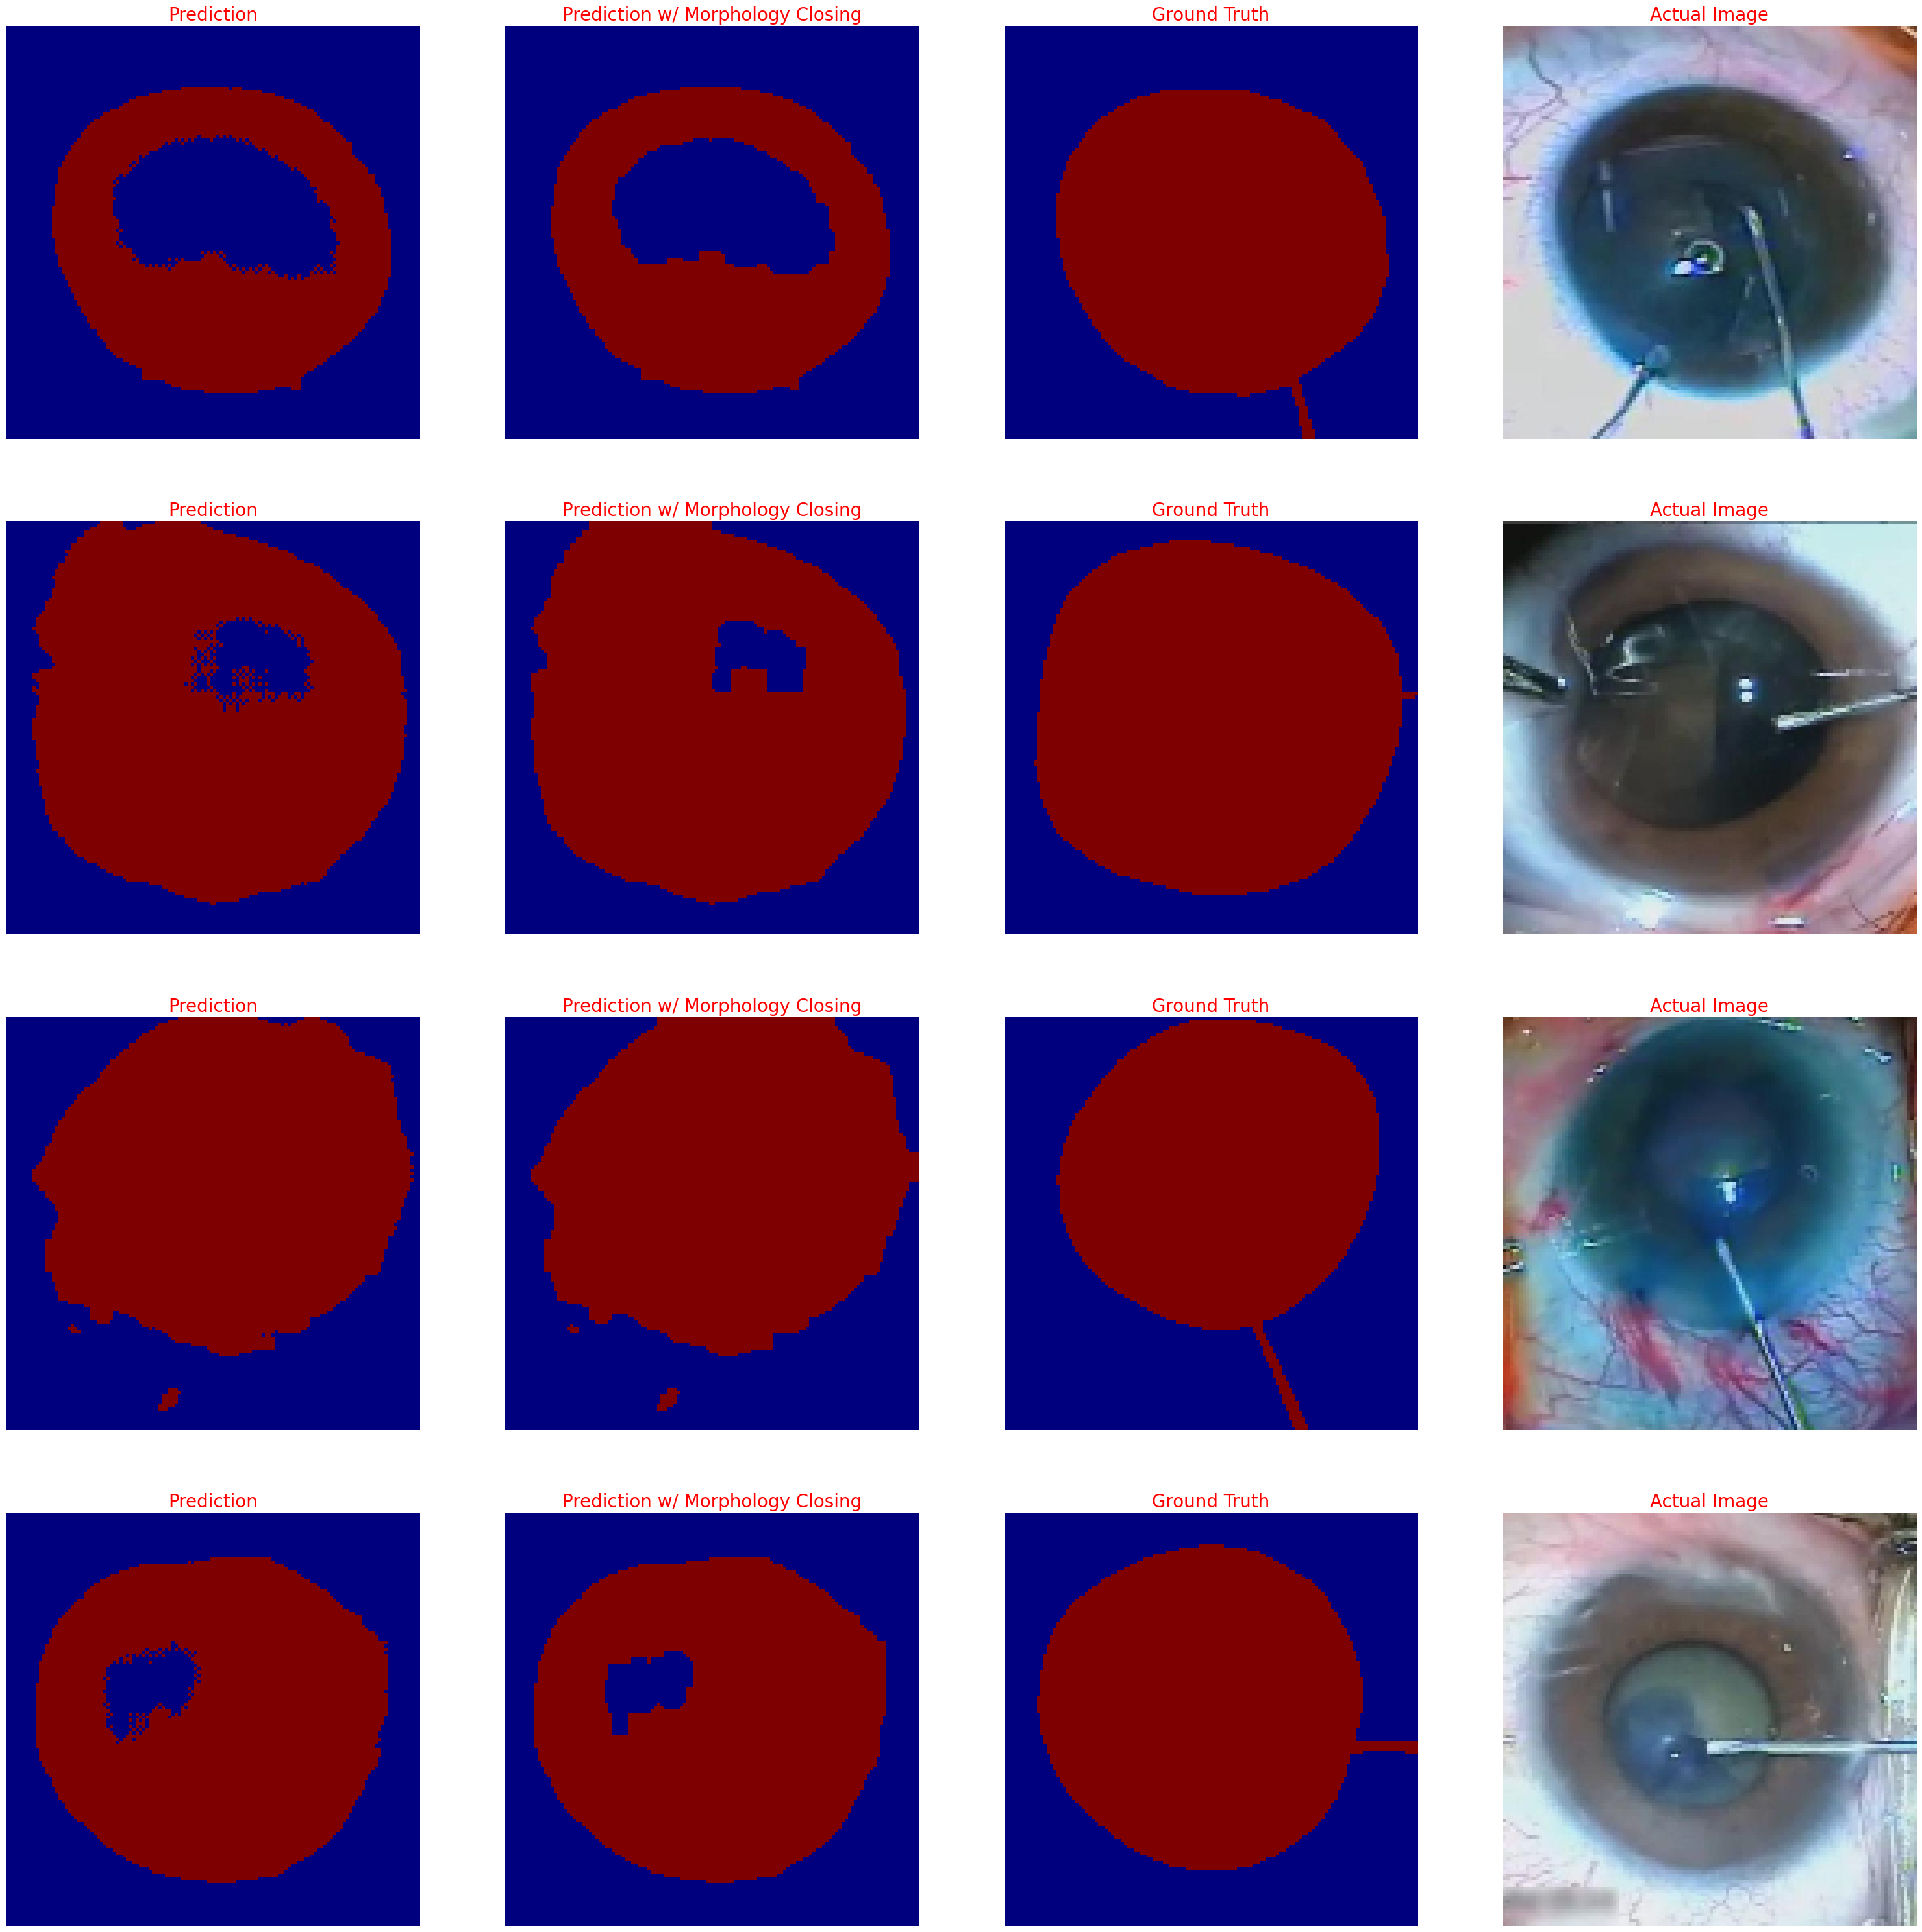

In [52]:
# Select a Test Data Batch
img, mask = next(iter(test))

# Make Prediction
pred = unet2.predict(img)
plt.figure(figsize=(38,38))

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4, 4, 1+k*4)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction', color='red', size=20)

    # Plot the Predicted Mask
    plt.subplot(4, 4, 2+k*4)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed_image = cv2.morphologyEx(i.numpy().astype('uint8'), cv2.MORPH_CLOSE, kernel)
    plt.imshow(closed_image,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction w/ Morphology Closing', color='red', size=20)

    # Plot the Groundtruth Mask
    plt.subplot(4, 4, 3+k*4)
    plt.imshow(mask[k], cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Ground Truth', color='red', size=20)

    # Plot the Actual Image
    plt.subplot(4, 4, 4+k*4)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image', color='red', size=20)
    k += 1
    if k == 4: break

plt.show()

#### Test With Cataract Dataset

In [53]:
# Load Cataract OG Image and Mask Image Path
test_image_path = []
test_mask_path = []
for root, dirs, files in os.walk(TEST_PREDICT_DIR):
    for file in files:
        path_og = os.path.join(root,file)
        path_mask = os.path.join(TEST_PREDICT_DIR,file)
        test_image_path.append(path_og)
        test_mask_path.append(path_mask)

# Verify Length and Consistency OG and Mask Image
print(len(test_image_path))
print(test_image_path[1])
print(len(test_mask_path))
print(test_mask_path[1])

# Load and Grayscale Mask Image
test_masks = []
for path in tqdm(test_mask_path):
    mask = cv2.imread(path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    test_masks.append(mask)

# Load and Grayscale OG Image
test_images = []
for path in tqdm(test_image_path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(image)

# Resize Dataset OG and Mask Image
X = [resize_image(image) for image in test_images]
y = [resize_mask(mask) for mask in test_masks]

# Change Dataset Into TensorFlow Dataset
X_test = tf.data.Dataset.from_tensor_slices(X)
y_test = tf.data.Dataset.from_tensor_slices(y)

# Zip Dataset
test = tf.data.Dataset.zip((X_test, y_test))

# Dataset Pipelining
test = test.batch(BATCH_SIZE_SEG)

3
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/katarak_matur1.jpg
3
/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/katarak_matur1.jpg


100%|██████████| 3/3 [00:00<00:00, 56.71it/s]


1/1 [==============================] - 0s 96ms/step


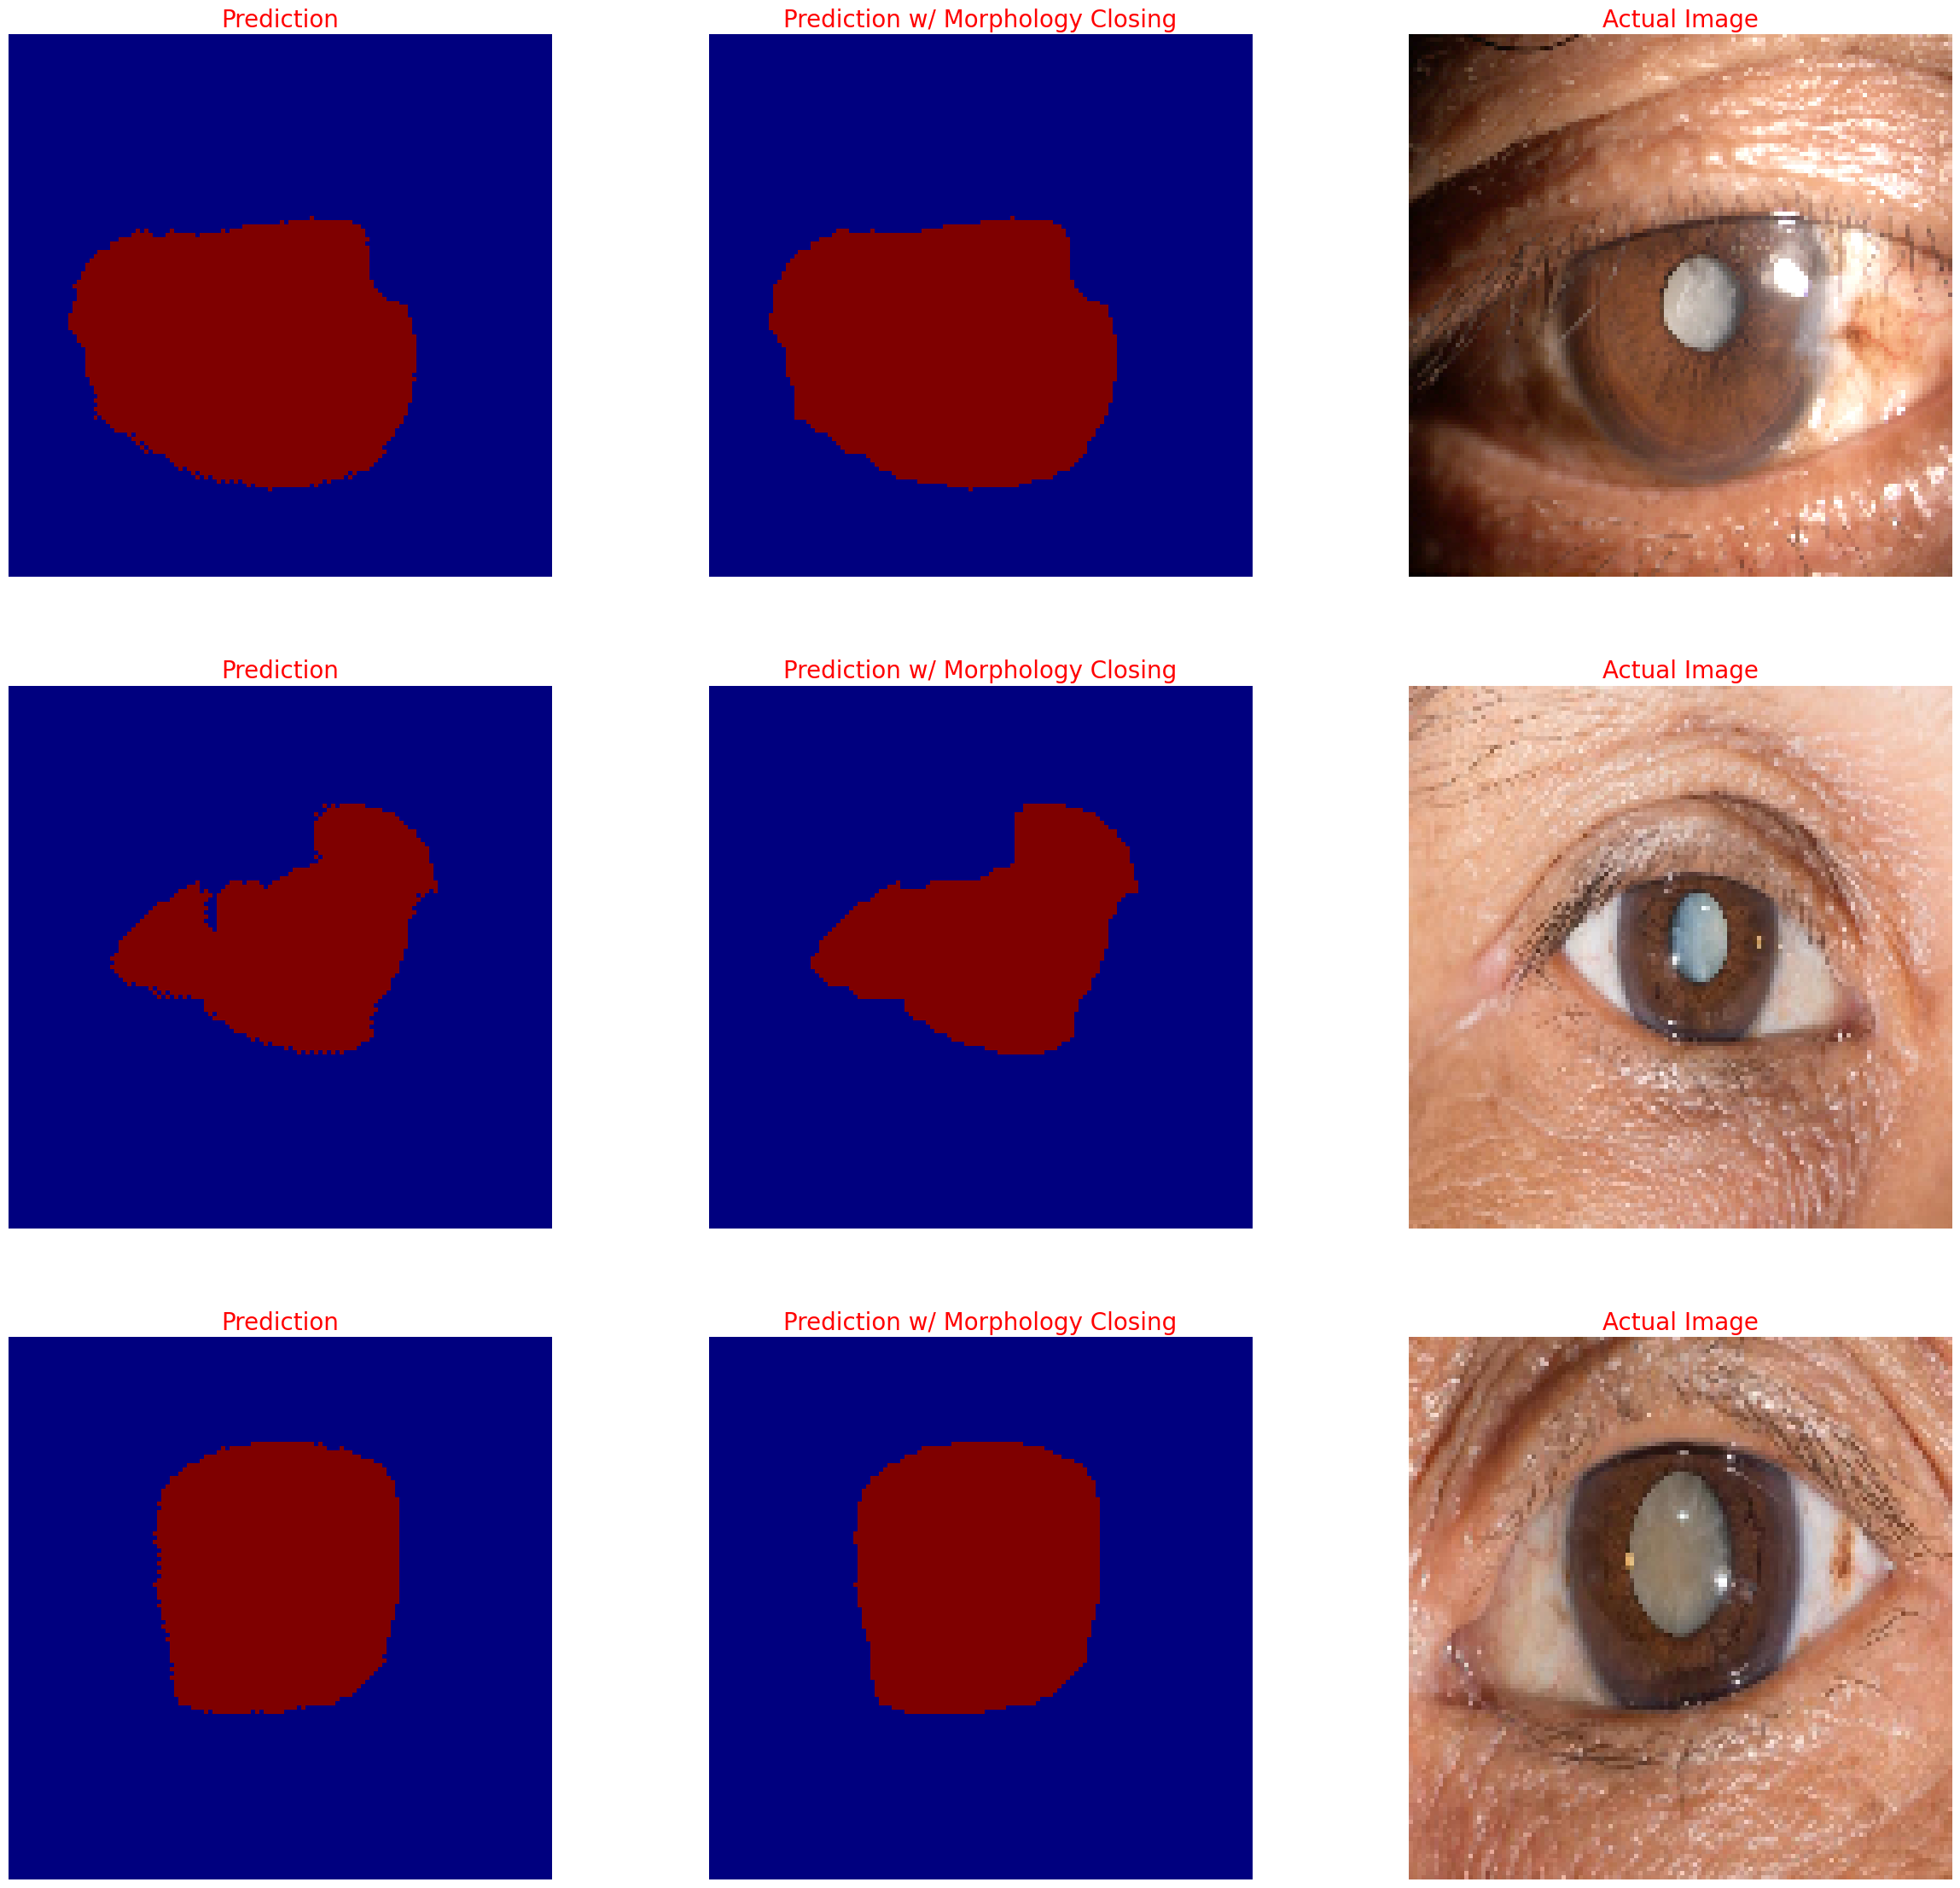

In [54]:
# Select a Cataract Test Data Batch
img, mask = next(iter(test))

# Make Prediction
pred = unet2.predict(img)
plt.figure(figsize=(30,38))

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4, 3, 1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction', color='red', size=20)

    # Plot the Predicted Mask
    plt.subplot(4, 3, 2+k*3)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed_image = cv2.morphologyEx(i.numpy().astype('uint8'), cv2.MORPH_CLOSE, kernel)
    plt.imshow(closed_image,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction w/ Morphology Closing', color='red', size=20)

    # Plot the Actual Image
    plt.subplot(4, 3, 3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image', color='red', size=20)
    k += 1
    if k == 4: break

plt.show()

## Save Model with TensorFlow Lite Converter

In [55]:
# Export Model to SavedModel Format
tf.saved_model.save(unet, SAVE_MODEL_PATH)

# Convert SavedModel to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model(SAVE_MODEL_PATH)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the Model
tflite_model_file = pathlib.Path(SAVE_MODEL_PATH + 'model.tflite')
tflite_model_file.write_bytes(tflite_model)

6473572